In [2]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data, train,  energy_lj, get_forces, MLP
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
from utils import radial_distribution_function

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [5]:
rng = default_rng(23)


def langevin_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    lc: float
):
    """Langevin step: MD in NVT ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    lc: Parameters Langevin dynamics

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    com = torch.mean(v, axis=0)
    v -= com

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1., size=(v.shape))

    # Verlet part of MD step
    v = v + 0.5 * f * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1.,size=(v.shape))

    return r, v, f

## Run MD

In [6]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

# 3d cluster
clus3d_without_0 = torch.tensor(
    [
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

# Refence energy: tensor(-9.1530)

In [7]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [8]:
# compute LJ energy
energy1 = energy_lj(clus3d)
energy2 = energy1
energy3 = energy_lj(clus3d_without_0)

# set Boltzmann constant
beta = 40.
m = 1.0

beta1 = 40.
beta2 = 4.
beta3 = 4.

dt =1e-3



In [9]:
r = torch.clone(clus3d)
n_particles = len(r)
n_dimensions = r.shape[-1]

r1 = torch.clone(clus3d)
r2 = torch.clone(clus3d)
r3 = torch.clone(clus3d_without_0)

n_particles1 = len(r1)
n_dimensions1 = r1.shape[-1]
n_particles2 = len(r2)
n_dimensions2 = r2.shape[-1]
n_particles3 = len(r3)
n_dimensions3 = r3.shape[-1]

In [10]:

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

v1 = assign_MBv(n_particles1, beta1, m)
v2 = assign_MBv(n_particles2, beta2, m)
v3 = assign_MBv(n_particles3, beta3, m)

# compute initial forces
f = get_forces(energy_lj, r)

f1 = get_forces(energy_lj, r1)
f2 = get_forces(energy_lj, r2)
f3 = get_forces(energy_lj, r3)



In [11]:
# initialize number of MD steps
n_steps = int(10e5)

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log,1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

potential_energies1 = torch.empty((n_steps // n_log,1))
positions1 = torch.empty((n_steps // n_log, n_particles1, n_dimensions1))

potential_energies2 = torch.empty((n_steps // n_log,1))
positions2 = torch.empty((n_steps // n_log, n_particles2, n_dimensions2))

potential_energies3 = torch.empty((n_steps // n_log,1))
positions3 = torch.empty((n_steps // n_log, n_particles3, n_dimensions3))

In [12]:
# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])

# initialize langevin parameters
lgamma_1 = torch.tensor(1.0)
c1_1 = torch.exp(-lgamma_1*dt/2.0)
c2_1 = torch.sqrt((1.0-(c1_1*c1_1))/beta1)
lc_1 = torch.tensor([c1_1,c2_1])

# initialize langevin parameters
lgamma_1 = torch.tensor(1.0)
c1_1 = torch.exp(-lgamma_1*dt/2.0)
c2_1 = torch.sqrt((1.0-(c1_1*c1_1))/beta1)
lc_1 = torch.tensor([c1_1,c2_1])

# initialize langevin parameters
lgamma_2 = torch.tensor(1.0)
c1_2 = torch.exp(-lgamma_2*dt/2.0)
c2_2 = torch.sqrt((1.0-(c1_2*c1_2))/beta2)
lc_2 = torch.tensor([c1_2,c2_2])

# initialize langevin parameters
lgamma_3 = torch.tensor(1.0)
c1_3 = torch.exp(-lgamma_3*dt/2.0)
c2_3 = torch.sqrt((1.0-(c1_3*c1_3))/beta3)
lc_3 = torch.tensor([c1_3,c2_3])

In [70]:
# # run Langevin
# for i in range(n_steps):
#     if i % n_log == 0:
#         positions[i // n_log] = r
#         potential_energies[i// n_log] = energy_lj(r)
#     r, v, f = langevin_step(r, v, f,energy_lj, dt, lc)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions1[i // n_log] = r1
        potential_energies1[i// n_log] = energy_lj(r1)
    r1, v1, f1 = langevin_step(r1, v1, f1, energy_lj, dt, lc_1)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions2[i // n_log] = r2
        potential_energies2[i// n_log] = energy_lj(r2)
    r2, v2, f2 = langevin_step(r2, v2, f2, energy_lj, dt, lc_2)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions3[i // n_log] = r3
        potential_energies3[i// n_log] = energy_lj(r3)
    r3, v3, f3 = langevin_step(r3, v3, f3, energy_lj, dt, lc_3)


In [13]:
# torch.save(potential_energies1, "potential_energies1")
# torch.save(potential_energies2, "potential_energies2")
# torch.save(potential_energies3, "potential_energies3")

# torch.save(positions1, "positions1")
# torch.save(positions2, "positions2")
# torch.save(positions3, "positions3")

potential_energies1 = torch.load('potential_energies1')
potential_energies2 = torch.load('potential_energies2')
potential_energies3 = torch.load('potential_energies3')

positions1 = torch.load('positions1')
positions2 = torch.load('positions2')
positions3 = torch.load('positions3')




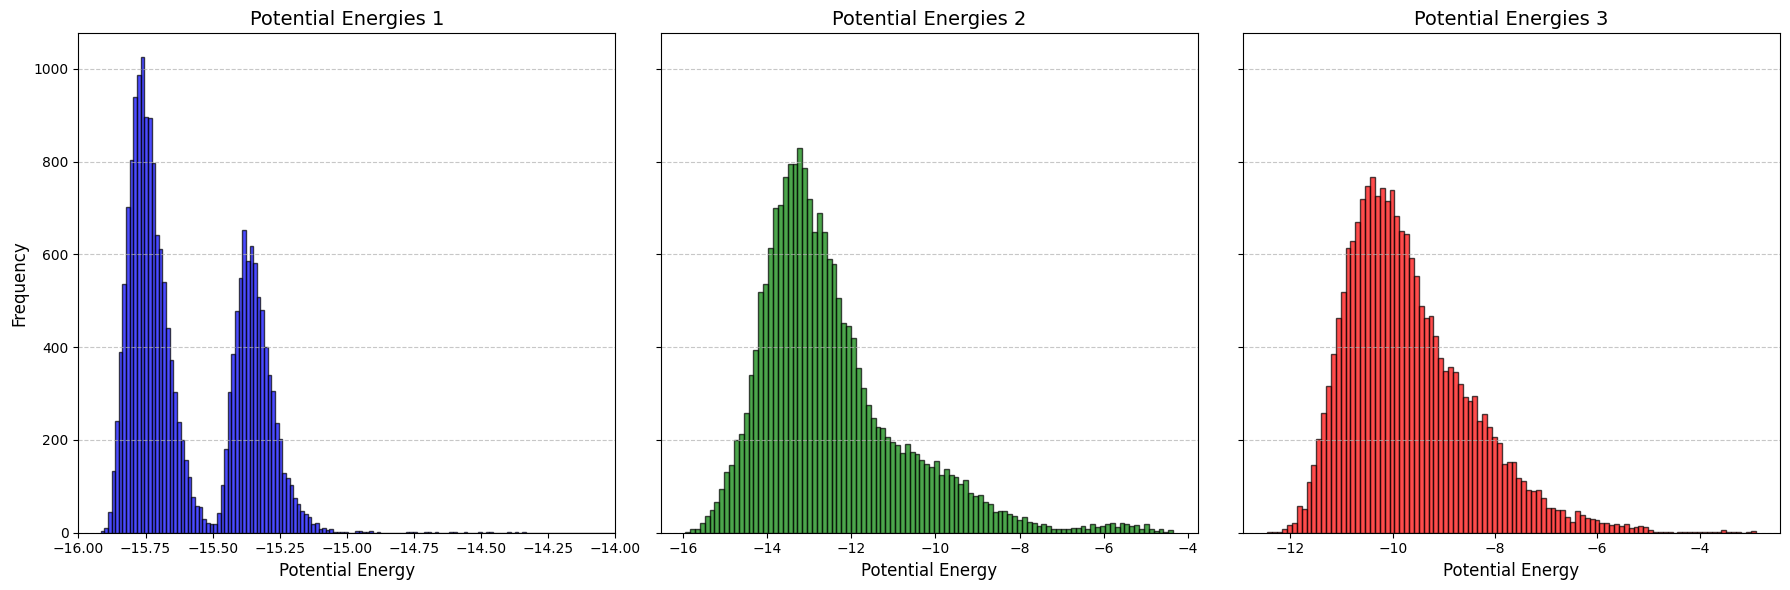

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each dataset in a separate subplot
axes[0].hist(potential_energies1, bins=500, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Potential Energies 1', fontsize=14)
axes[0].set_xlabel('Potential Energy', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlim(-16, -14)

axes[1].hist(potential_energies2, bins=100, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Potential Energies 2', fontsize=14)
axes[1].set_xlabel('Potential Energy', fontsize=12)

axes[2].hist(potential_energies3, bins=100, color='red', alpha=0.7, edgecolor='black')
axes[2].set_title('Potential Energies 3', fontsize=14)
axes[2].set_xlabel('Potential Energy', fontsize=12)

# Add grid to all subplots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
rdf1 = radial_distribution_function(positions1.detach().numpy())
rdf2 = radial_distribution_function(positions2.detach().numpy())
rdf3 = radial_distribution_function(positions3.detach().numpy())

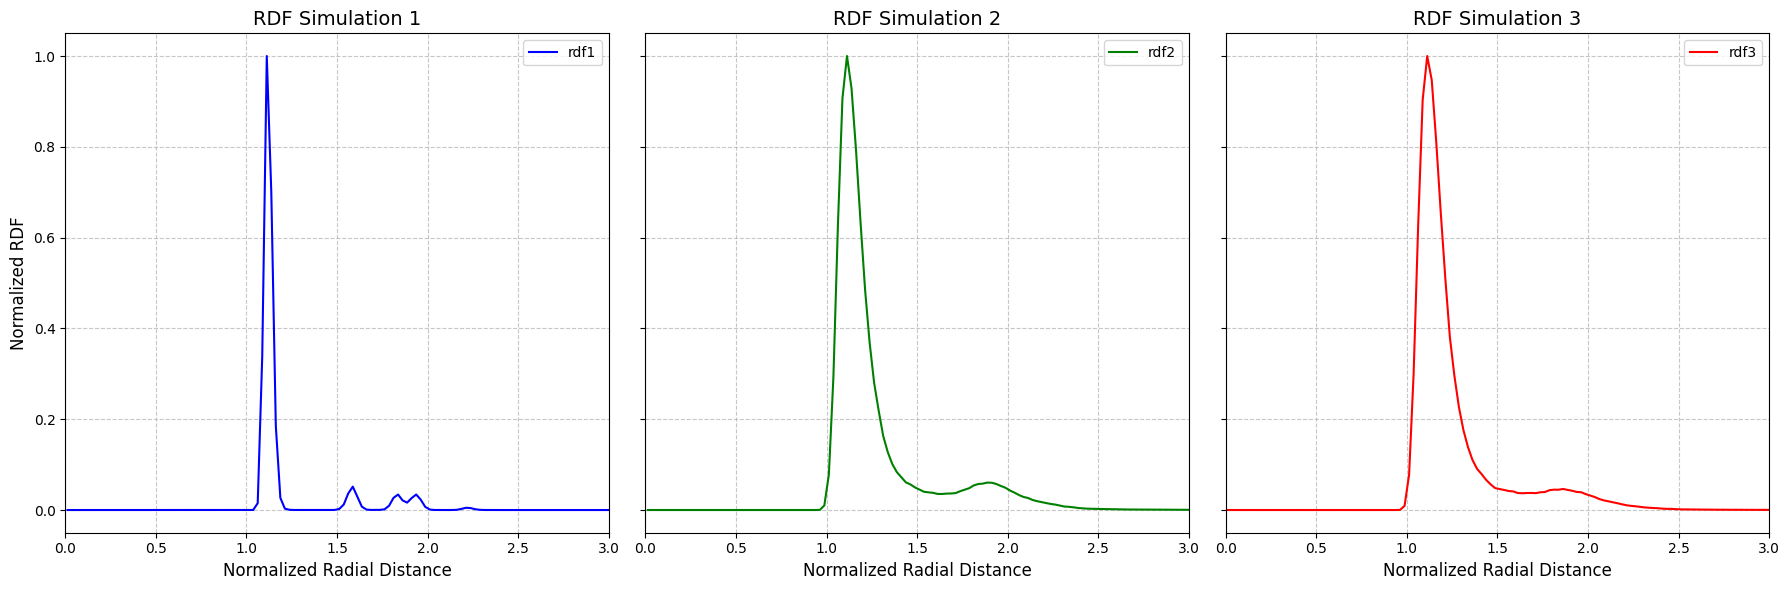

In [19]:



fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot rdf1
axes[0].plot(rdf1[0], rdf1[1] / rdf1[1].max(), label='rdf1', color='blue')
axes[0].set_title('RDF Simulation 1', fontsize=14)
axes[0].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[0].set_ylabel('Normalized RDF', fontsize=12)
axes[0].legend()

# Plot rdf2
axes[1].plot(rdf2[0], rdf2[1] / rdf2[1].max(), label='rdf2', color='green')
axes[1].set_title('RDF Simulation 2', fontsize=14)
axes[1].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[1].legend()

# Plot rdf3
axes[2].plot(rdf3[0], rdf3[1] / rdf3[1].max(), label='rdf3', color='red')
axes[2].set_title('RDF Simulation 3', fontsize=14)
axes[2].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[2].legend()

axes[0].set_xlim(0,3)
axes[1].set_xlim(0,3)
axes[2].set_xlim(0,3)

# Add grid to all subplots
for ax in axes:
    ax.grid(linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# plt.plot(rdf[0], rdf[1] / rdf[1].max())


## Behler-Parinello symmetry functions

In [21]:
def f_c(distance, r_cut):
    return torch.where(distance <= r_cut, 0.5 * (torch.cos(np.pi * distance / r_cut) + 1), 0)

"Bare" Behler-Parrinello functions, these functions do not involve a sum over neighboring atoms.

In [27]:
def g_1_func(distances, r_cut):
    return f_c(distances, r_cut)

def g_2_func(distances, eta, r_cut):
    return torch.exp(-eta*distances**2) * f_c(distances, r_cut)

def g_3_func(distances, kappa, r_cut):
    return torch.cos(kappa * distances) * f_c(distances, r_cut)

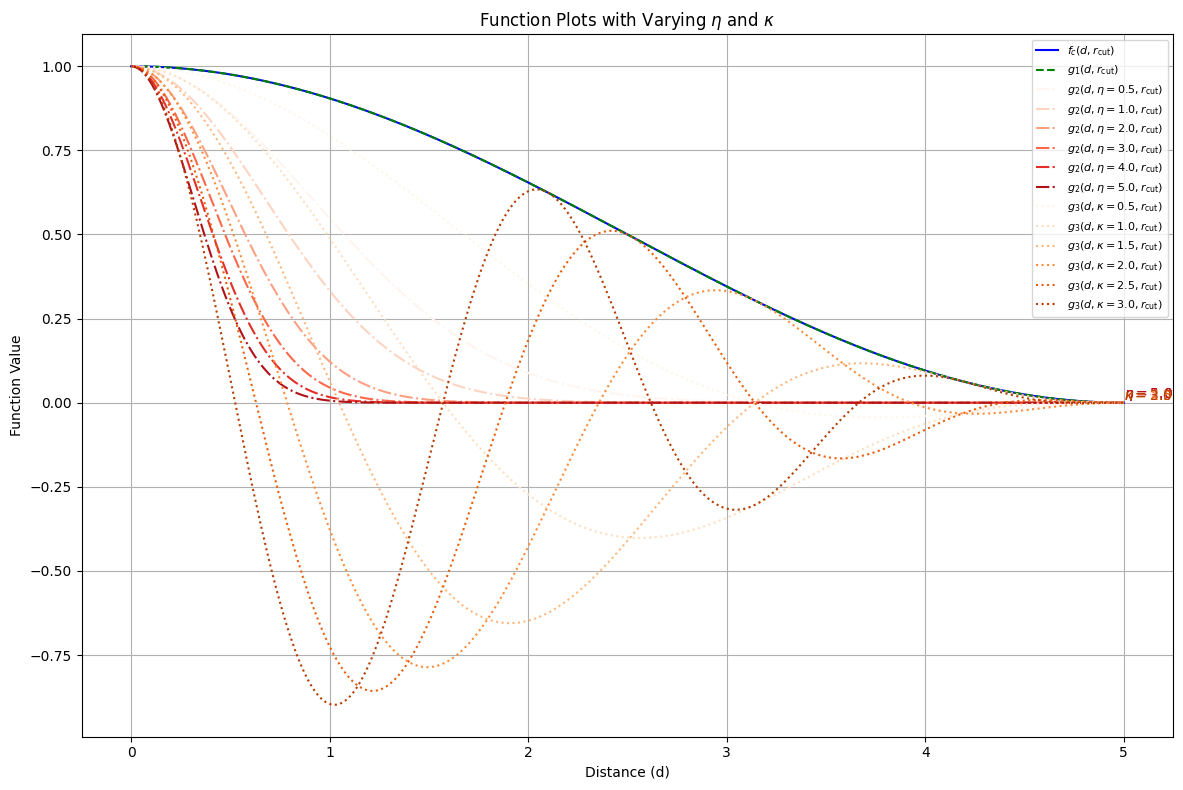

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def f_c(distance, r_cut):
    return torch.where(distance <= r_cut, 0.5 * (torch.cos(np.pi * distance / r_cut) + 1), torch.tensor(0.0))

def g_1_func(distances, r_cut):
    return f_c(distances, r_cut)

def g_2_func(distances, eta, r_cut):
    return torch.exp(-eta * distances**2) * f_c(distances, r_cut)

def g_3_func(distances, kappa, r_cut):
    return torch.cos(kappa * distances) * f_c(distances, r_cut)

# Set parameters
r_cut = 5.0   # Cut-off distance
eta_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]  # More values of eta for g_2
kappa_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]  # More values of kappa for g_3
distances = torch.linspace(0, r_cut, 500)  # Generate 500 points between 0 and r_cut

# Compute the function values for f_c and g_1
f_values = f_c(distances, r_cut)
g1_values = g_1_func(distances, r_cut)

# Convert tensors to numpy arrays for plotting
f_values_np = f_values.numpy()
g1_values_np = g1_values.numpy()

# Define color maps
g2_cmap = plt.cm.Reds  # Color map for g_2 (shades of red)
g3_cmap = plt.cm.Oranges  # Color map for g_3 (shades of orange)

# Plot the functions
plt.figure(figsize=(12, 8))

# Plot f_c and g_1 (which are the same for this case)
plt.plot(distances.numpy(), f_values_np, label=r"$f_c(d, r_{\text{cut}})$", linestyle='-', color='blue')
plt.plot(distances.numpy(), g1_values_np, label=r"$g_1(d, r_{\text{cut}})$", linestyle='--', color='green')

# Plot g_2 for different values of eta (using shades of red)
for i, eta in enumerate(eta_values):
    label = r"$g_2(d, \eta = %.1f, r_{\text{cut}})$" % eta
    g2_values = g_2_func(distances, eta, r_cut)
    color = g2_cmap(i / len(eta_values))  # Get color from the red color map
    line, = plt.plot(distances.numpy(), g2_values.numpy(), label=label, linestyle='-.', color=color)
    
    # Add text label on the curve
    plt.text(distances[-1].item(), g2_values[-1].item(), f"$\\eta={eta}$", color=color, fontsize=10, verticalalignment='bottom')

# Plot g_3 for different values of kappa (using shades of orange)
for i, kappa in enumerate(kappa_values):
    label = r"$g_3(d, \kappa = %.1f, r_{\text{cut}})$" % kappa
    g3_values = g_3_func(distances, kappa, r_cut)
    color = g3_cmap(i / len(kappa_values))  # Get color from the orange color map
    line, = plt.plot(distances.numpy(), g3_values.numpy(), label=label, linestyle=':', color=color)
    
    # Add text label on the curve
    plt.text(distances[-1].item(), g3_values[-1].item(), f"$\\kappa={kappa}$", color=color, fontsize=10, verticalalignment='bottom')

# Add labels and legend
plt.title(r"Function Plots with Varying $\eta$ and $\kappa$")
plt.xlabel("Distance (d)")
plt.ylabel("Function Value")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [44]:
etas = np.geomspace(0.01, 5.0, 10)
kappas = np.linspace(0.5, 5.0, 10)

In [ ]:
random_indices = torch.randint(0, positions.size(0), (n,))

torch.cdist(positions, positions)
positions[0]

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

Behler-Parrinello symmetry defined as sum over all neighbors

In [75]:
# Distances refer to the distance array
# of the particle under consideration to all other particles
def g_1_feature(distances, r_cut):
    return torch.sum(g_1_func(distances, r_cut))

def g_2_feature(distances, eta, r_cut):
    return torch.sum(g_2_func(distances, eta, r_cut))

def g_3_feature(distances, kappa, r_cut):
    return torch.sum(g_3_func(distances, kappa, r_cut))

In [ ]:
g_1_func(distances)